In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime as time

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Mixed State Generator

## Partial Trace Method 
N=4, pure ---> N=2, mixed

1. Create a **random pure state** vector for the combined system (N=4, linearcombination of random basis with random coeffs)
2. Create a 4x4 **density matrix** from random state vector above
3. Perform **partial trace** on any 2x2 base (resulting mixed 2x2 density matrix is independent of the chosen base traced over)

In [5]:
def create_invertible():
    mat = np.random.uniform(size=(4,4))        # or complex??
    if np.abs(np.linalg.det(mat)) < 1e-10:     # eps to avoid rounding errors
        return create_invertible()
    return mat

def create_combined_pure():
    basis = create_invertible()
    coeffs = np.random.uniform(size=4)
    coeffs = coeffs / np.sum(coeffs)

    rho = np.zeros((4,4))
    for i, vec in enumerate(basis):
        vec = vec / np.linalg.norm(vec)
        rho += coeffs[i] * np.outer( vec, vec)
    return rho

# Test
A = create_combined_pure()
A
np.trace(A)



array([[0.2312729 , 0.17949038, 0.17336894, 0.17057954],
       [0.17949038, 0.15112721, 0.1587128 , 0.17714388],
       [0.17336894, 0.1587128 , 0.19109267, 0.25086955],
       [0.17057954, 0.17714388, 0.25086955, 0.42650722]])

1.0

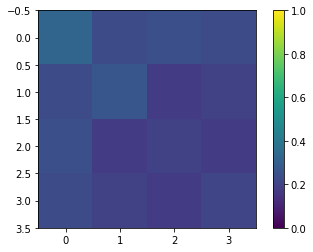

In [103]:
plt.imshow(create_combined_pure(), vmin=0, vmax=1)
plt.colorbar()

Ist random.Uniform eine gute Wahl? die werte in der dichte matrix sind ziemlich gleichverteilt. Sollte ich komplexe Werte zulassen? 

In [3]:
def partial_trace(rho, basis=np.array([[1,0], [0,1]])):
    #trace is performed on traced basis
    reduced = np.zeros((2,2))
    for i in range(2):
        bra = np.kron(np.eye(2), basis[i])
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Test
partial_trace(create_combined_pure(), basis=np.array([[1,0], [0,1]]))

array([[0.47202139, 0.33829643],
       [0.33829643, 0.52797861]])

In [104]:
combined = create_combined_pure()
print('combined system\n', combined)

reduced = partial_trace(combined, basis=np.array([[1,0], [0,1]]))
print('\nreduced system\n', reduced)

# Test Tr(rho^2)
np.trace(reduced.dot(reduced))

combined system
 [[0.07719394 0.14148323 0.0936614  0.12528045]
 [0.14148323 0.47359673 0.3010945  0.31973527]
 [0.0936614  0.3010945  0.19699344 0.21230883]
 [0.12528045 0.31973527 0.21230883 0.25221589]]

reduced system
 [[0.55079067 0.41339667]
 [0.41339667 0.44920933]]


0.8469530045814464

In [109]:
# Define Wrapper function
def random_mixed_1qubit():
    return partial_trace(create_combined_pure())

test_rho = random_mixed_1qubit()
np.trace(test_rho)

1.0

# 1-Qubit Measurement

Habe ich mit bloch vektoren alle möglichen observablen abgedeckt?

State Tomography: How many measurements are needed to correctly identify the state? 3^n for pure

For 1-Qubit: 3 Measurements are needed
--> Bloch vector

Simple Approach: make much more measurements: 100

1. generate Random vectors m to measure along
2. measure along each m very often

In [139]:
rho = random_mixed_1qubit()
rho
np.trace(rho)

array([[0.68268242, 0.2942936 ],
       [0.2942936 , 0.31731758]])

1.0000000000000002

In [141]:
def bloch2mat(vec):
    assert vec.shape[0] == 3
    s1 = np.matrix([[0,1],[1,0]])
    s2 = np.matrix([[0,-1j],[1j,0]])
    s3 = np.matrix([[1,0],[0,-1]])

    r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3

    return (np.eye(2) + r_sig) /2

def random_pure_1qubit():
    vec = np.random.uniform(size=3)
    vec = vec / np.sum(vec)
    return np.real(bloch2mat(vec))

np.trace(random_pure_1qubit())


1.0

In [193]:
# Generate random measurements 
m_amt = 100

def random_measurement(rho, m_amt=m_amt):
  observables = np.array([random_pure_1qubit() for _ in range(m_amt)])
  measurements = np.array([np.trace(observables[i].dot(rho)) for i in range(m_amt)])
  return measurements.astype('float')


measurements = random_measurement(random_mixed_1qubit())
measurements.mean()
measurements.std()

0.5492475683124245

0.06559950427525897

In [194]:
meas = random_measurement(random_mixed_1qubit(), m_amt=100000)

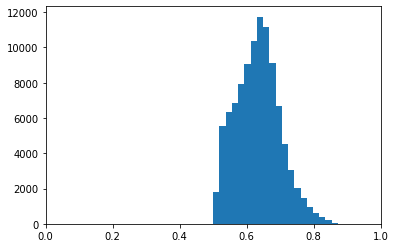

In [196]:
a=plt.hist(meas, bins=20)
a=plt.xlim(0,1)

# Tomograpy FFN

### Create Dataset

In [197]:
# n_samples = 10000
# PATH = f"data/n{n_samples}_{time.now()}.csv"

# with open(PATH, 'w') as f:
#   writer = csv.writer(f)
#   for _ in trange(n_samples):
#     rho = random_mixed_1qubit()
#     a=writer.writerow(rho.reshape(4))
#     a=writer.writerow(random_measurement(rho))

### Open dataset

In [198]:
filename = 'data/n10000_2022-04-09 20:38:19.674375.csv'

y = np.empty((0,4))
X = np.empty((0,m_amt))

with open(filename, 'r') as f:
  reader = csv.reader(f)
  i=0
  for line in tqdm(reader):
    if i % 2 ==0:
      y = np.vstack((y, np.array(np.array(line).astype('float'))))
    else:
      X = np.vstack((X, np.array(np.array(line).astype('float'))))
    i+=1


X_train, X_left, y_train, y_left = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_valid, X_treasure, y_valid, y_treasure = train_test_split(
    X_left, y_left, test_size=0.4, random_state=42)

X.shape
y.shape
X_train.shape[0]
X_valid.shape[0]
X_treasure.shape[0]

20000it [00:04, 4242.47it/s]


(10000, 100)

(10000, 4)

7000

1800

1200

In [199]:
class CustomDataset(Dataset):

  def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [200]:
tomography_train_dataset = CustomDataset(X_train, y_train)
tomography_valid_dataset = CustomDataset(X_valid, y_valid)

In [201]:
# Define the batch sizes
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

# Create data loaders from the datasets for the current task
# Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)
tomography_vaild_dataloader = DataLoader(tomography_valid_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, drop_last=True)

Feed Forward Neural Network

In [278]:
class FeedForwardNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,4),
    )

  def forward(self, x):
    return self.layers(x)

In [279]:
# Function for training the network
def train(net, train_epochs, train_dataloader, optimizer, criterion):

    losses = np.array([])
    train_accuracies = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses, loss.clone().detach().cpu().numpy())

            # # Check training accuracy
            # binary_predictions = (outputs>0.5).float()
            # accuracy = (binary_predictions == target).float().mean()
            # train_accuracies.append(accuracy)

    return losses #, train_accuracies

In [302]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net = FeedForwardNet().to(device)

# Loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

losses = train(net, 25, tomography_train_dataloader, optimizer, criterion)

cpu


100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


<Figure size 720x288 with 0 Axes>

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Tomography Dataset Loss over Iterations')

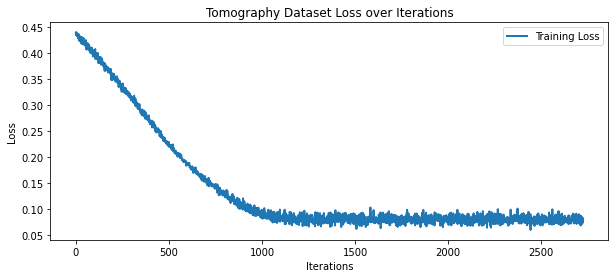

In [303]:
plt.figure(figsize=(10,4))
plt.plot(losses, lw=2, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Tomography Dataset Loss over Iterations')

# Inference

[0.18399672 0.23333696 0.23333696 0.81600328]
[0.41536146 0.32018188 0.34202337 0.42282188]


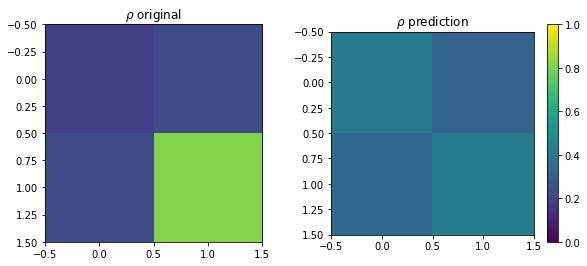

In [325]:
rho_orig = random_mixed_1qubit()
measurement = torch.Tensor(random_measurement(rho_orig))
rho_pred = net.forward(measurement.to(device)).detach().cpu().numpy().reshape(2,2)

print(rho_orig.reshape(4))
print(rho_pred.reshape(4))
fig, axs = plt.subplots(1,2, figsize=(10,4))
a=axs[0].imshow(rho_orig, vmin=0, vmax=1)
a=axs[0].set_title('$\\rho$ original')
a=axs[1].set_title('$\\rho$ prediction')
a=axs[1].imshow(rho_pred, vmin=0, vmax=1)
a=fig.colorbar(a)

Lernt nur den Durchschnitt!

Verbesserungsansätze: 
- netzwerk vergrößern
  - nichts gebracht
- andere loss function mit mehr gewicht für outliers
  - bereits MSE verwendet, was mehr weight auf outliers gibt as MAE=L1, konvergiert bei 0.02 training loss
  - MAE bringt nichts, resultiert in 0.7 training loss
- berücksichtigen, dass information auf offdiagonaler redundant ist
  - siehe neues notebook error von bloch vektoren

Briegel fragen was genau es bringt im AE nicht über die dichtematrix zu gehen sondern direkt auf kompakteste repräsentation zu lernen.